# DCGAN in TensorFlow 2.0

출처 : https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

print(tf.__version__)

2.0.0


### 이미지 로드, 파라미터 설정

In [2]:
# mnist data set load
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# 이미지를 [-1, 1]로 정규화합니다.
train_images = (train_images - 127.5) / 127.5 

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Generator network 구성

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    # assert : output shape 다시한번 확인. 해당 shape이 아니면 assertion error 일으킴.
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # DCGAN의 특징 generator의 마지막이 tanh activation function
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

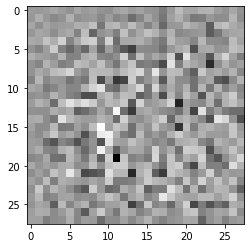

In [4]:
# 노이즈 만들어서 generator에 넣은 후 나오는 이미지 출력

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator network 구성

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [6]:
# image를 discriminator에 넣었을 때 판별값이 나옴
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00029961]], shape=(1, 1), dtype=float32)


In [7]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### loss 계산

In [8]:
# real image를 넣었을 때 1이 나오게, fake image를 넣었을 때 0이 나오게 학습
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
# fake image를 넣었을 때 1이 나오도록 학습
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
# hyper parameter 설정 
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# 출력 용도로 random noise 생성
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### training function

In [12]:
# `tf.function` 이 데코레이터는 함수를 "컴파일" 한다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # generator에 noise 넣고 fake image 생성
        generated_images = generator(noise, training=True)
        
        # discriminator에 real image와 fake image 넣고 판별값 리턴
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # fake image를 discriminator가 1로 학습 하도록 업데이트
        gen_loss = generator_loss(fake_output)
        # real image loss와 fake image loss 합한 total loss 리턴
        disc_loss = discriminator_loss(real_output, fake_output)

    # tape에 기록하며 자동미분 실행
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [13]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    # 이미지 넣고 학습 실행. 
    for image_batch in dataset:
      train_step(image_batch)

    # 이미지를 10 epoch마다 출력
#     display.clear_output(wait=True)
    if epoch % 10 == 0:
        generate_and_save_images(generator,epoch + 1,seed)
    
    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [14]:
# noise 넣고 이미지 확인
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False : (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됨
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

CPU times: user 3min 54s, sys: 31.3 s, total: 4min 26s
Wall time: 10min 10s


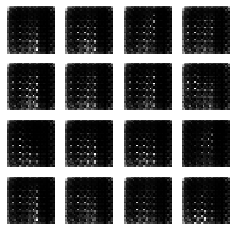

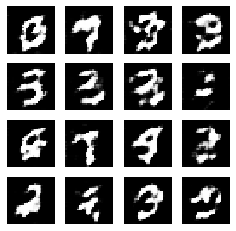

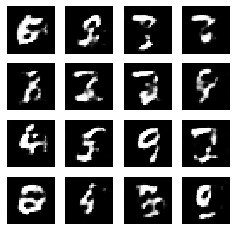

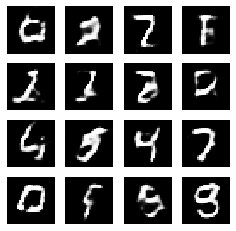

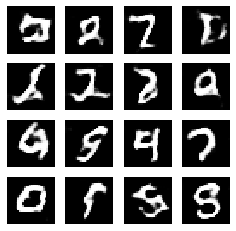

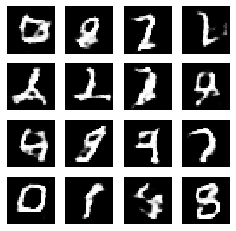

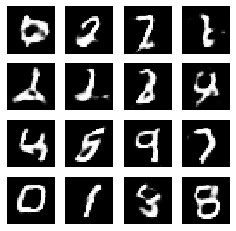

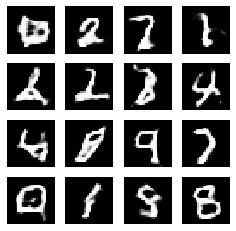

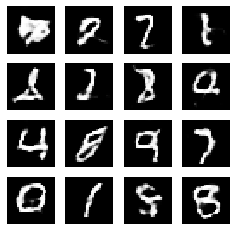

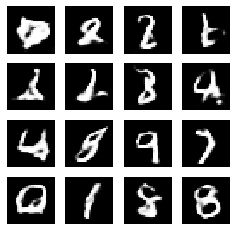

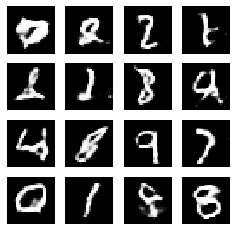

In [15]:
%%time
train(train_dataset, EPOCHS)